In [769]:
import numpy as np
import scipy.integrate as integrate
import math
import matplotlib.pyplot as plt

In [770]:
timecalc = 9

# load the data
p_ind_read, frame_read, x_read, y_read = np.genfromtxt(
    "./20170202c059_RPE1_CAG_H2B_Halotag_TMR80pM_nonlam_non_starve_ctrl_info.txt",
    unpack=True,
)

# data
data = np.array([p_ind_read, frame_read, x_read, y_read])
data = data.T

In [771]:
# print all shapes
print("data.shape", data.shape)
print("data[0] : ", data[0])

data.shape (11579, 4)
data[0] :  [  1.     0.   148.37 108.4 ]


In [772]:
class Nucleosome:
    def __init__(self, p_ind, data):
        self.p_ind = p_ind
        self.traj = self.get_traj(data)
        self.in_time = self.traj[0, 0]
        self.out_time = self.traj[-1, 0]
        
    
    def get_traj(self, data):
        traj = data[data[:, 0] == self.p_ind]
        traj = traj[:, 1:4]                         # have only [frame, x, y]
        return traj
    

In [773]:
# initialize nucleosomes
nucleosomes = []
for p_ind in np.unique(data[:, 0]):
    nucleosomes.append(Nucleosome(p_ind, data))

In [774]:
# print all shapes
# print("nucleosomes[0].traj.shape", nucleosomes[0].traj.shape)
# print("nucleosomes[0].traj[0] : ", nucleosomes[0].traj[0])

# print all in and out times
# for n in nucleosomes:
#     print("nucleosome {} : in_time = {}, out_time = {}".format(n.p_ind, n.in_time, n.out_time))

In [775]:
# plot all trajectories with different colors for each nucleosome based on p_ind
# for n in nucleosomes:
#     color = np.random.rand(3,)
#     plt.scatter(n.traj[:, 1], n.traj[:, 2], color=color)

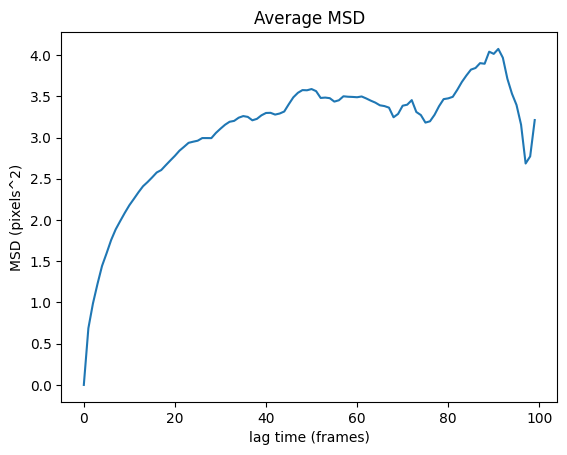

In [776]:
# calculate average MSD for each lag time 

num_frames = int(max(data[:, 1]))
if min(data[:, 1]) == 0:
    num_frames += 1

msd = np.zeros(num_frames)
msd_count = np.zeros(num_frames)

for n in nucleosomes:
    for i in range(1, n.traj.shape[0]):
        # vectorized
        # print(n.traj[i,0])
        msd[i] += np.sum((n.traj[i:, 1:3] - n.traj[0:-i, 1:3])**2)
        msd_count[i] += n.traj.shape[0] - i

# average
msd[0] = 0
msd_count[0] = 1
msd = msd / msd_count
# print(msd)

# plot
plt.plot(msd)
plt.xlabel("lag time (frames)")
plt.ylabel("MSD (pixels^2)")
plt.title("Average MSD")
plt.show()

# save
np.savetxt("msd.txt", msd)


In [777]:
# calculate self part of van Hove function for each lag time
r_vals = np.arange(0, 10.01, 0.02)
# print(r_vals.shape)
van_hove = np.zeros((num_frames, r_vals.shape[0]-1))

for n in nucleosomes:
    for i in range(1, n.traj.shape[0]):
        # vectorized
        dist = np.linalg.norm(n.traj[i:, 1:3] - n.traj[0:-i, 1:3], axis=1)
        hist, _ = np.histogram(dist, bins=r_vals)
        van_hove[i, :] += hist

# average
van_hove = van_hove / len(nucleosomes)

print(f"shape of van hove : {van_hove.shape}")

# save 
np.savetxt("van_hove.txt", van_hove)



shape of van hove : (100, 500)


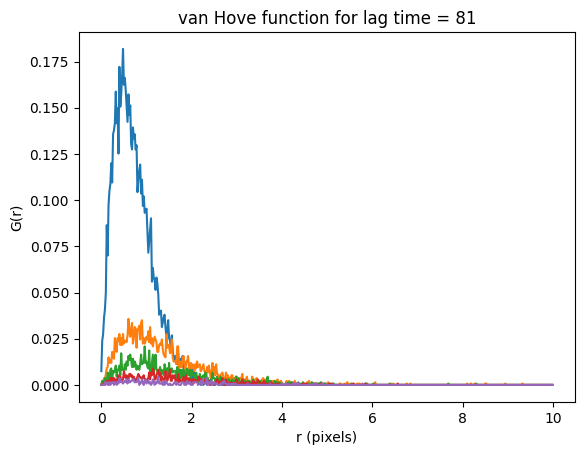

In [778]:
# plot van Hove function for lag time = i
for i in range(1, num_frames, 20):
    plt.plot(r_vals[:-1], van_hove[i, :])
    plt.xlabel("r (pixels)")
    plt.ylabel("G(r)")
    plt.title(f"van Hove function for lag time = {i}")
    # plt.show()

Lucy-Richardson Iterative Algorithm

$\\$
$P^{k+1}(M) = P^{k}(M) \int \frac{G_s(r)}{G^{k}_s(r)}e^{\frac{-r^2}{M}}dr$, $\\ where \\$
$G^k_s(r) = \int P^k(M)e^{\frac{-r^2}{M}}dM$

In [779]:
# get P_init as the guessed value of P(M, t)

P = np.zeros((num_frames, r_vals.shape[0]-1))
print(f"shape of P : {P.shape}")

M_vals = np.linspace(0, max(msd), len(r_vals)-1)
M_vals[0] = 1e-10
print(f"shape of M_vals : {M_vals.shape}")

shape of P : (100, 500)
shape of M_vals : (500,)


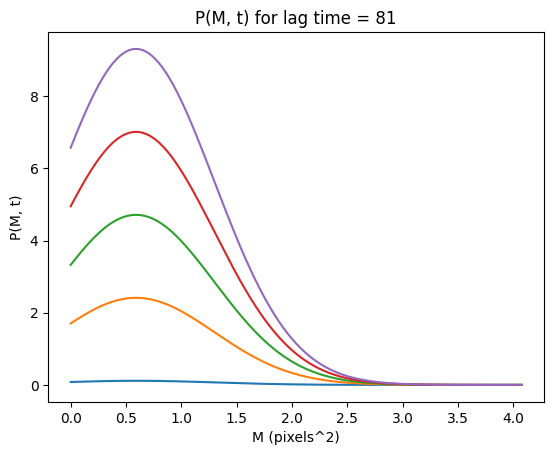

In [780]:
# initialize P
a1 = 1.15
a = 1.0
a0 = 0.59
for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        P[i, j] = a1 * np.exp(-a * (M_vals[j] - a0)**2)*i*(0.1)

# plot P
for i in range(1, num_frames, 20):
    plt.plot(M_vals, P[i, :])
    plt.xlabel("M (pixels^2)")
    plt.ylabel("P(M, t)")
    plt.title(f"P(M, t) for lag time = {i}")
    # plt.show()

In [781]:
# integrate to get G_pred
G_pred = np.zeros((num_frames, r_vals.shape[0]-1))
print(f"shape of G_pred : {G_pred.shape}")

# try and integrate $G^k_s(r) = \int P^k(M)e^{\frac{-r^2}{M}}dM$
# do this in a vectorized way using numpy

shape of G_pred : (100, 500)


shape of G_pred : (100, 500)


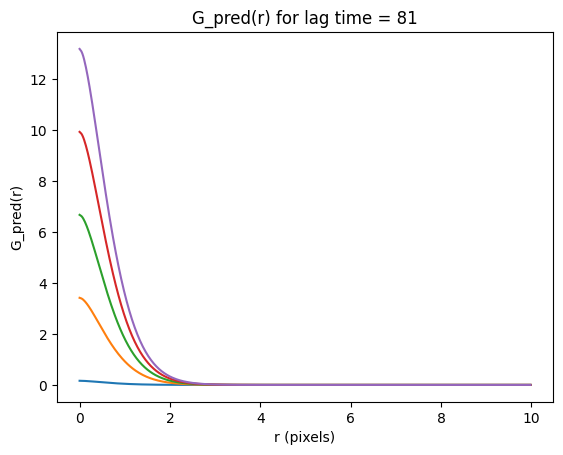

In [782]:
# integrate using trapezoidal rule over M
for i in range(G_pred.shape[0]):
    for j in range(G_pred.shape[1]):
        G_pred[i, j] = np.trapz(P[i, :]*np.exp(-r_vals[j]**2/M_vals), M_vals)
    
# normalize G_pred



# shape 
print(f"shape of G_pred : {G_pred.shape}")

# plot G_pred
for i in range(1, num_frames, 20):
    plt.plot(r_vals[:-1], G_pred[i, :])
    plt.xlabel("r (pixels)")
    plt.ylabel("G_pred(r)")
    plt.title(f"G_pred(r) for lag time = {i}")
    # plt.show()

/tmp/ipykernel_2442/741134877.py:7: RuntimeWarning: invalid value encountered in divide
  P[i, j] = P[i, j] * np.trapz(van_hove[i, :]/G_pred[i, :], r_vals[:-1])


shape of P : (100, 500)


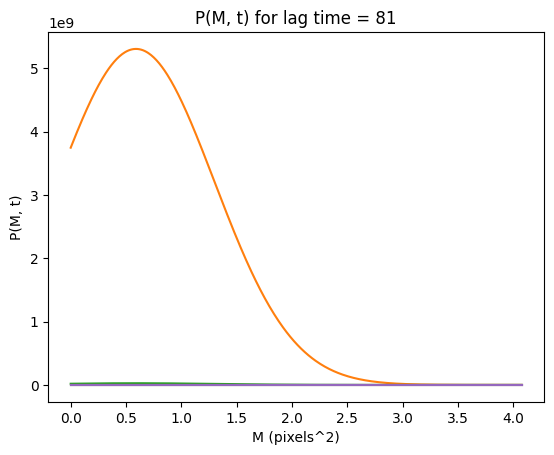

In [783]:
# now update P using $P^{k+1}(M) = P^{k}(M) \int \frac{G_s(r)}{G^{k}_s(r)}e^{\frac{-r^2}{M}}dr$
# do this in a vectorized way using numpy

# update P
for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        P[i, j] = P[i, j] * np.trapz(van_hove[i, :]/G_pred[i, :], r_vals[:-1])


# shape
print(f"shape of P : {P.shape}")

# plot P
for i in range(1, num_frames, 20):
    plt.plot(M_vals, P[i, :])
    plt.xlabel("M (pixels^2)")
    plt.ylabel("P(M, t)")
    plt.title(f"P(M, t) for lag time = {i}")
    # plt.show()
